### Parameter Tuning and Model Selection

In this Jupyter Notebook, cleaned data done in previous notebook will be used for model creation, hyperparameter tuning and choose the best model for prediction.

### Import package

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score,roc_curve,confusion_matrix,plot_confusion_matrix,classification_report,precision_score,recall_score,f1_score,accuracy_score,plot_roc_curve, confusion_matrix
import joblib

### Read traning and testing dataset

In [2]:
train = pd.read_csv('clean_train.csv')
test = pd.read_csv('clean_test.csv')

### Split dataset into x and y variable

In [3]:
x_train = train.drop(columns=['Churn'])
y_train = train['Churn']
x_test = test.drop(columns=['Churn'])
y_test = test['Churn']

#### For this project, classification model that will be used are Logistic Regression, Decision Tree and Random Forest

### Model fitting (with default parameter)

In [4]:
logistic = LogisticRegression()
dec_tree = DecisionTreeClassifier()
ran_forest = RandomForestClassifier()

### Fit training dataset with model

In [5]:
logistic.fit(x_train,y_train)
dec_tree.fit(x_train,y_train)
ran_forest.fit(x_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Check cross validation score between model

In [6]:
log_cv_0 = cross_val_score(logistic,x_train,y_train,cv=5)*100
tree_cv_0 = cross_val_score(dec_tree,x_train,y_train,cv=5)*100
forest_cv_0 = cross_val_score(ran_forest,x_train,y_train,cv=5)*100

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

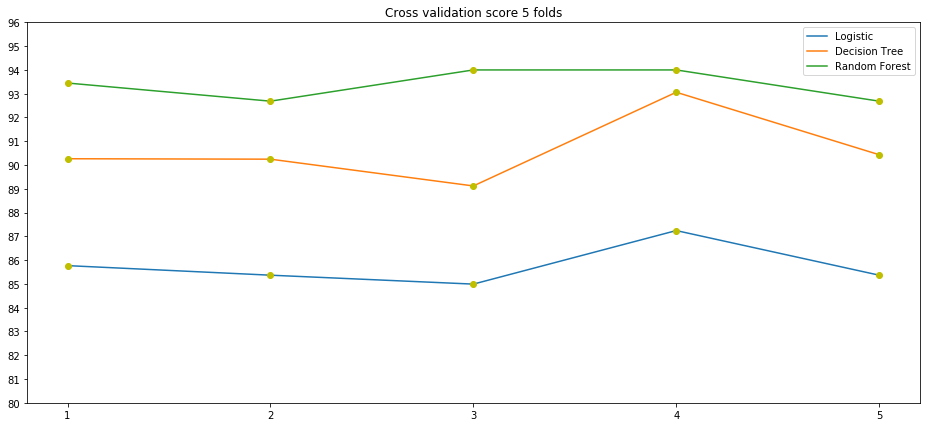

In [7]:
plt.figure(figsize=(16,7))
plt.title('Cross validation score 5 folds')
plt.plot([1,2,3,4,5],log_cv_0)
plt.plot([1,2,3,4,5],tree_cv_0)
plt.plot([1,2,3,4,5],forest_cv_0)
plt.plot([1,2,3,4,5],log_cv_0,'yo')
plt.plot([1,2,3,4,5],tree_cv_0,'yo')
plt.plot([1,2,3,4,5],forest_cv_0,'yo')
plt.legend(['Logistic','Decision Tree','Random Forest'])
plt.xticks(np.arange(1,6))
plt.yticks(np.arange(80,97,1))
plt.show()

##### Logistic regression and decision tree cross validation accross 5 folds fluctuate more than random forest. Let's check if CV will be more stable after hyperparameter tuning.

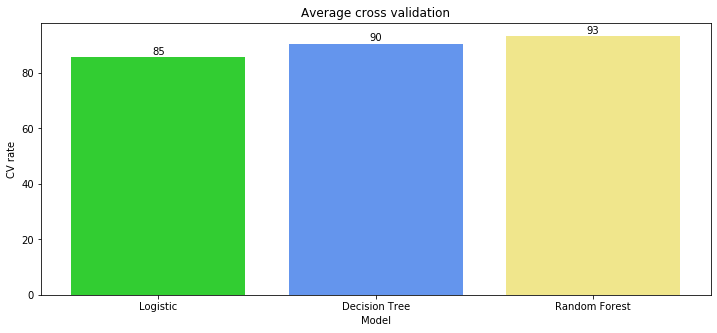

In [90]:
plt.figure(figsize=(12,5))
plt.title('Average cross validation')
plot = plt.bar(['Logistic','Decision Tree','Random Forest'],[log_cv_0.mean(),tree_cv_0.mean(),forest_cv_0.mean()],color=['limegreen','cornflowerblue','khaki'])
plt.ylabel('CV rate')
plt.xlabel('Model')
for i in plot:
    height = i.get_height()
    plt.text(i.get_x() + i.get_width()/2.,
             1.002*height,'%d'% int(height),ha='center',va='bottom' )
plt.show()

##### With default parameter, random forest has the highest cross validation score with 93%. 

### Hyperparameter tuning

By changing model parameter to certain value, we hope that our model performance can improve in classifying churning rate.

For this project, RandomizedSearch will be used instead of GridSearch for time efficiency.

In [9]:
def tuning(model,parameter,n_cv):
    random = RandomizedSearchCV(model, param_distributions=parameter, cv = n_cv)
    random.fit(x_train,y_train)
    best_param = random.best_params_
    
    return best_param

#### Parameter for logistic regression

Parameter to be tested:

- penalty
- solver
- max iteration

In [10]:
log_param = {
    'penalty':['l1','l2','elasticnet','none'],'solver':['newton-cg','lbfgs','liblinear','sag','saga'],'max_iter':[1,10,100,1000,10000]
}

log_best = tuning(logistic,log_param,5)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

#### Parameter for decision tree

Parameter to be tested:

- criterion
- splitter
- max_depths
- min_samples_splits
- min_samples_leafs

In [21]:
tree_param = {
    'max_depth':[1,2,3,4,5],
    'min_samples_split':[2,4,6,8,10],
    'min_samples_leaf':[1,2,3,4,5],
    'criterion':['gini','entropy'],
    'splitter':['best','random']
}

tree_best = tuning(dec_tree,tree_param,5)

#### Parameter for random forest

Parameter to be tested:

- n_estimators
- max_features
- min_sample_split
- min_samples_leaf
- bootstrap

In [27]:
forest_param = {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
               'max_features': ['auto', 'sqrt','log2'],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
}

forest_best = tuning(ran_forest,forest_param,5)

### Best parameters according to RandomizedSearch

In [13]:
print(log_best)

{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 1000}


In [14]:
log_new = LogisticRegression(solver='liblinear',penalty='l2',max_iter=1000)
log_new.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
print(tree_best)

{'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 4, 'criterion': 'gini'}


In [23]:
tree_new = DecisionTreeClassifier(splitter='best',min_samples_split=2,min_samples_leaf=4,max_depth=4,criterion='gini')
tree_new.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [28]:
print(forest_best)

{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'bootstrap': False}


In [29]:
forest_new = RandomForestClassifier(n_estimators=200,min_samples_split=10,min_samples_leaf=2,max_features='auto',bootstrap=False)
forest_new.fit(x_train,y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Comparing default parameters with hyperparameter tuning result

In [24]:
log_acc_0 = round(logistic.score(x_test,y_test)*100,2)
log_acc_1 = round(log_new.score(x_test,y_test)*100,2)

print('Logistic regression accuracy with default parameter',log_acc_0,'%')
print('Logistic regression accuracy with hyperparameter tuning',log_acc_1,'%')
print('After tuning, accuracy improve by around',round(log_acc_1-log_acc_0,2),'%')

Logistic regression accuracy with default parameter 84.26 %
Logistic regression accuracy with hyperparameter tuning 85.16 %
After tuning, accuracy improve by around 0.9 %


In [30]:
tree_acc_0 = round(dec_tree.score(x_test,y_test)*100,2)
tree_acc_1 = round(tree_new.score(x_test,y_test)*100,2)

print('Decision tree accuracy with default parameter',tree_acc_0,'%')
print('Decision tree accuracy with hyperparameter tuning',tree_acc_1,'%')
print('After tuning, accuracy improve by around',round(tree_acc_1-tree_acc_0,2),'%')

Decision tree accuracy with default parameter 92.5 %
Decision tree accuracy with hyperparameter tuning 92.95 %
After tuning, accuracy improve by around 0.45 %


In [31]:
forest_acc_0 = round(ran_forest.score(x_test,y_test)*100,2)
forest_acc_1 = round(forest_new.score(x_test,y_test)*100,2)

print('Random forest accuracy with default parameter',forest_acc_0,'%')
print('Random forest accuracy with hyperparameter tuning',forest_acc_1,'%')
print('After tuning, accuracy improve by around',round(forest_acc_1-forest_acc_0,2),'%')

Random forest accuracy with default parameter 94.15 %
Random forest accuracy with hyperparameter tuning 94.15 %
After tuning, accuracy improve by around 0.0 %


##### Hyperparameter tuning improve all model's accuracy except for random forest.

##### However, using accuracy as the only metrics might not be ideal especially since this dataset has an imbalanced target value. (85% for target 0, 15% for target 1)

### Compare models after hyperparameter tuning

##### Cross validation

In [32]:
log_cv_1 = cross_val_score(log_new,x_train,y_train,cv=5)*100
tree_cv_1 = cross_val_score(tree_new,x_train,y_train,cv=5)*100
forest_cv_1 = cross_val_score(forest_new,x_train,y_train,cv=5)*100

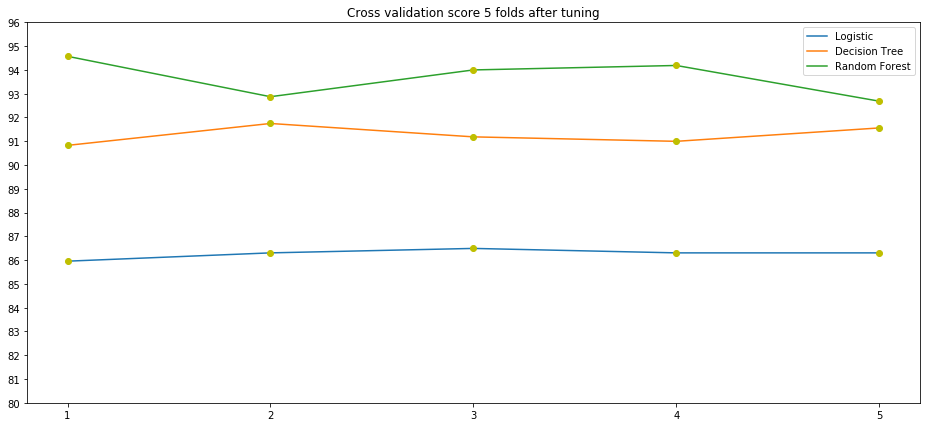

In [33]:
plt.figure(figsize=(16,7))
plt.title('Cross validation score 5 folds after tuning')
plt.plot([1,2,3,4,5],log_cv_1)
plt.plot([1,2,3,4,5],tree_cv_1)
plt.plot([1,2,3,4,5],forest_cv_1)
plt.plot([1,2,3,4,5],log_cv_1,'yo')
plt.plot([1,2,3,4,5],tree_cv_1,'yo')
plt.plot([1,2,3,4,5],forest_cv_1,'yo')
plt.legend(['Logistic','Decision Tree','Random Forest'])
plt.xticks(np.arange(1,6))
plt.yticks(np.arange(80,97,1))
plt.show()

##### Flucuation in decision tree and logistic regression minimize -> more stable accross folds

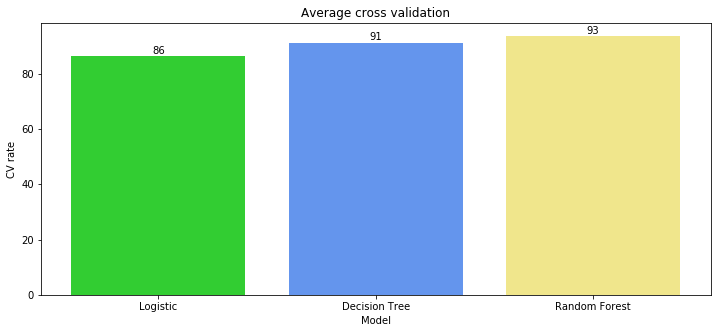

In [89]:
plt.figure(figsize=(12,5))
plt.title('Average cross validation')
plot = plt.bar(['Logistic','Decision Tree','Random Forest'],[log_cv_1.mean(),tree_cv_1.mean(),forest_cv_1.mean()],color=['limegreen','cornflowerblue','khaki'])
plt.ylabel('CV rate')
plt.xlabel('Model')
for i in plot:
    height = i.get_height()
    plt.text(i.get_x() + i.get_width()/2.,
             1.002*height,'%d'% int(height),ha='center',va='bottom' )
plt.show()

##### Decision tree improve and logistic regression improves by 1%
##### Tuning does not affect random forest cross validation score -> similar to accuracy score

### Classification report

In [35]:
print('Classification report logistic regression:\n',classification_report(y_test,log_new.predict(x_test)))
print('Classification report Decision tree classifier:\n',classification_report(y_test,tree_new.predict(x_test)))
print('Classification report random forest classifier:\n',classification_report(y_test,forest_new.predict(x_test)))

Classification report logistic regression:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       572
           1       0.45      0.19      0.27        95

    accuracy                           0.85       667
   macro avg       0.66      0.58      0.59       667
weighted avg       0.82      0.85      0.82       667

Classification report Decision tree classifier:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       572
           1       0.85      0.61      0.71        95

    accuracy                           0.93       667
   macro avg       0.90      0.80      0.84       667
weighted avg       0.93      0.93      0.92       667

Classification report random forest classifier:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       572
           1       0.98      0.60      0.75        95

    accuracy                           0

### Confusion matrix

![title](https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg)

- True positive (TP): correct positive prediction
- False positive (FP): incorrect positive prediction
- True negative (TN): correct negative prediction
- False negative (FN): incorrect negative prediction

##### Logistic regression

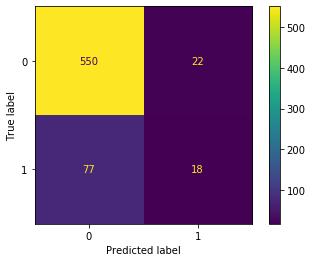

In [37]:
plot_confusion_matrix(log_new,x_test,y_test,values_format='0.0f')
plt.show()

True Negative = 550

False Negative = 77

False Positive = 22

True Positive = 18

##### Decision tree

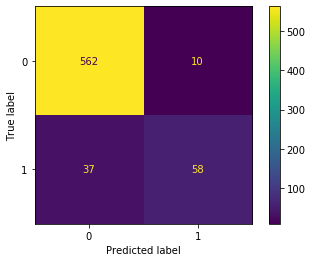

In [39]:
plot_confusion_matrix(tree_new,x_test,y_test,values_format='0.0f')
plt.show()

True Negative = 562

False Negative = 37

False Positive = 10

True Negative = 58

##### Random forest

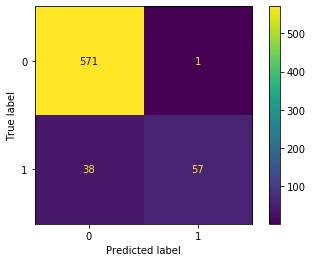

In [41]:
plot_confusion_matrix(forest_new,x_test,y_test,values_format='0.0f')
plt.show()

True Negative = 571

False Negative = 38

False Positive = 1

True Positive = 57

### Recall - If actual is 1, how many times can model predict 1?

Recall positive (sensitivity): $\displaystyle \frac {TP} {TP + FN}$

Recall negative (specificity): $\displaystyle \frac {TN} {TN + FP}$

In [60]:
log_recall_pos = recall_score(y_test,log_new.predict(x_test),pos_label=1)
log_recall_neg = recall_score(y_test,log_new.predict(x_test),pos_label = 0)
tree_recall_pos = recall_score(y_test,tree_new.predict(x_test),pos_label=1)
tree_recall_neg = recall_score(y_test,tree_new.predict(x_test),pos_label = 0)
forest_recall_pos = recall_score(y_test,forest_new.predict(x_test),pos_label=1)
forest_recall_neg = recall_score(y_test,forest_new.predict(x_test),pos_label = 0)

In [80]:
pd.DataFrame({'Logistic':[log_recall_pos,log_recall_neg],'Decision Tree':[tree_recall_pos,tree_recall_neg],'Random Forest':[forest_recall_pos,forest_recall_neg]},index=['churn','non churn'])

,Logistic,Decision Tree,Random Forest
churn,0.189474,0.610526,0.600000
non churn,0.961538,0.982517,0.998252


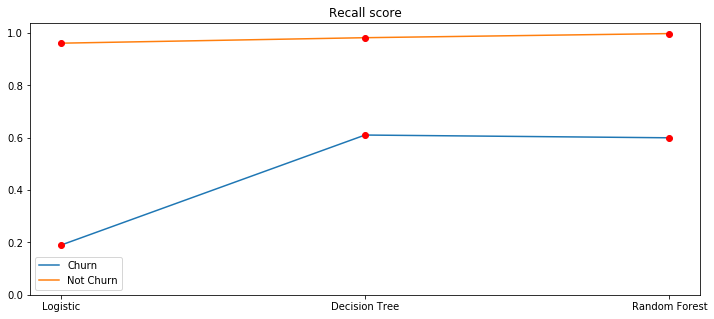

In [81]:
plt.figure(figsize=(12,5))
plt.title('Recall score')
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_recall_pos,tree_recall_pos,forest_recall_pos])
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_recall_neg,tree_recall_neg,forest_recall_neg])
plt.legend(['Churn','Not Churn'])
plt.plot([log_recall_pos,tree_recall_pos,forest_recall_pos],'ro')
plt.plot([log_recall_neg,tree_recall_neg,forest_recall_neg],'ro')
plt.yticks(np.arange(0,1.2,0.2))
plt.show()

##### Once again, according to recall score, decision tree is the best model for predicting churn target
##### While random forest is the best for predicting non churning target

### Precision - If prediction is 1 how many times it is right?


Formula Precision Positive = $\displaystyle \frac {TP}{TP+FP}$ 

Formula Precision Negative = $ \displaystyle \frac {TN}{TN+FN}$ 

In [76]:
log_prec_pos = precision_score(y_test,log_new.predict(x_test),pos_label=1)
log_prec_neg = precision_score(y_test,log_new.predict(x_test),pos_label=0)
tree_prec_pos = precision_score(y_test,tree_new.predict(x_test),pos_label=1)
tree_prec_neg = precision_score(y_test,tree_new.predict(x_test),pos_label=0)
forest_prec_pos = precision_score(y_test,forest_new.predict(x_test),pos_label=1)
forest_prec_neg = precision_score(y_test,forest_new.predict(x_test),pos_label=0)

In [82]:
pd.DataFrame({'Logistic':[log_prec_pos,log_prec_neg],'Decision Tree':[tree_prec_pos,tree_prec_neg],'Random Forest':[forest_prec_pos,forest_prec_neg]},index=['churn','non churn'])

,Logistic,Decision Tree,Random Forest
churn,0.450000,0.852941,0.982759
non churn,0.877193,0.938230,0.937603


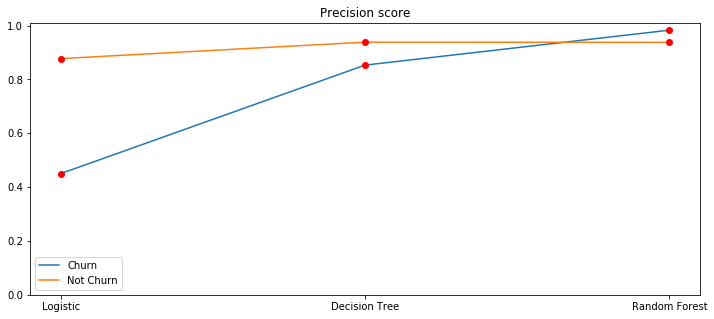

In [83]:
plt.figure(figsize=(12,5))
plt.title('Precision score')
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_prec_pos,tree_prec_pos,forest_prec_pos])
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_prec_neg,tree_prec_neg,forest_prec_neg])
plt.legend(['Churn','Not Churn'])
plt.plot([log_prec_pos,tree_prec_pos,forest_prec_pos],'ro')
plt.plot([log_prec_neg,tree_prec_neg,forest_prec_neg],'ro')
plt.yticks(np.arange(0,1.2,0.2))
plt.show()

##### Random forest produced the most precise prediction

### F1 Score - Harmonic mean between precision and recall

Formula = $\displaystyle 2 * (\frac {PrecisionP * RecallP }{PrecisionP + RecallP})$

In [46]:
f1_log_pos = f1_score(y_test,log_new.predict(x_test),pos_label=1)
f1_tree_pos = f1_score(y_test,tree_new.predict(x_test),pos_label=1)
f1_forest_pos = f1_score(y_test,forest_new.predict(x_test),pos_label=1)
f1_log_neg = f1_score(y_test,log_new.predict(x_test),pos_label=0)
f1_tree_neg = f1_score(y_test,tree_new.predict(x_test),pos_label=0)
f1_forest_neg = f1_score(y_test,forest_new.predict(x_test),pos_label=0)

In [85]:
pd.DataFrame({'Logistic':[f1_log_pos,f1_log_neg],'Decision Tree':[f1_tree_pos,f1_tree_neg],'Random Forest':[f1_forest_pos,f1_forest_neg]},index=['churn','not churn'])

,Logistic,Decision Tree,Random Forest
churn,0.266667,0.711656,0.745098
not churn,0.917431,0.959863,0.966977


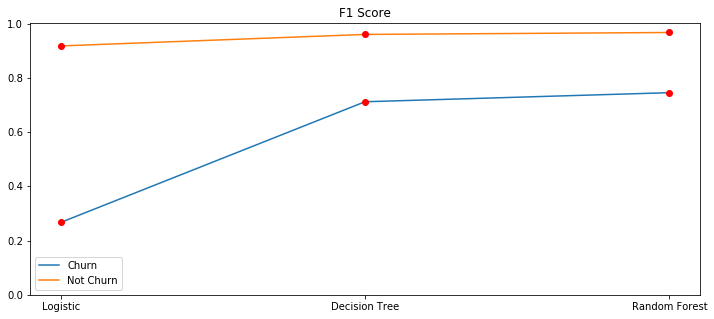

In [86]:
plt.figure(figsize=(12,5))
plt.title('F1 Score')
plt.plot(['Logistic','Decision Tree','Random Forest'],[f1_log_pos,f1_tree_pos,f1_forest_pos])
plt.plot(['Logistic','Decision Tree','Random Forest'],[f1_log_neg,f1_tree_neg,f1_forest_neg])
plt.plot([f1_log_pos,f1_tree_pos,f1_forest_pos],'ro')
plt.plot([f1_log_neg,f1_tree_neg,f1_forest_neg],'ro')
plt.yticks(np.arange(0,1.2,0.2))
plt.legend(['Churn','Not Churn'])
plt.show()

##### Logistic regression has the lowest f1 score in both positive and negative f1 score

### Balanced accuracy

Formula: $\displaystyle \frac {recallP + recallN}{2} $

calculated as the average of the proportion corrects of each class individually.

Can be used as alternative for accuracy score, especially for unbalanced dataset.

In [54]:
balacc_log = round(balanced_accuracy_score(y_test,log_new.predict(x_test),adjusted=False)*100,2)
balacc_tree = round(balanced_accuracy_score(y_test,tree_new.predict(x_test),adjusted=False)*100,2)
balacc_forest = round(balanced_accuracy_score(y_test,forest_new.predict(x_test),adjusted=False)*100,2)

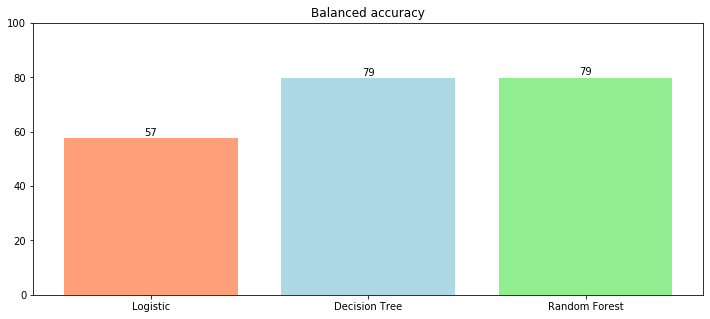

In [55]:
plt.figure(figsize=(12,5))
plt.title('Balanced accuracy')
plot = plt.bar(['Logistic','Decision Tree','Random Forest'],[balacc_log,balacc_tree,balacc_forest],color=['lightsalmon','lightblue','lightgreen'])
plt.yticks(np.arange(0,120,20))
for i in plot:
    height = i.get_height()
    plt.text(i.get_x() + i.get_width()/2.,
             1.002*height,'%d'% int(height),ha='center',va='bottom' )
plt.show()

### ROC AUC Score

Tells how much model is capable of distinguishing between classes. 

[sumber](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

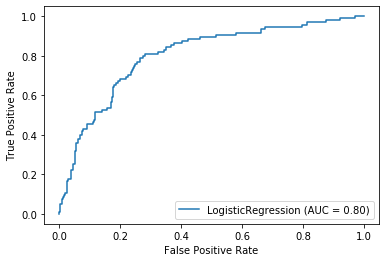

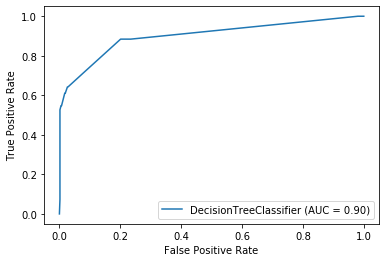

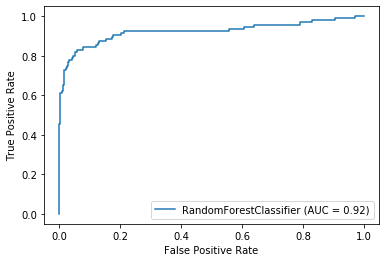

In [50]:
plot_roc_curve(log_new,x_test,y_test), plot_roc_curve(tree_new,x_test,y_test),plot_roc_curve(forest_new,x_test,y_test)
plt.show()

##### According AUC score, Random forest is the best in distinguishing between target labels.

### Evaluation Metrics insight

##### Overall, we can conclude that Logistic Regression perform poorly for this dataset, especially in predicting churn outcome (1 label), hence, we will not use Logistic Regression. 

##### In comparison, Decision Tree and Random Forest have similar score in most evaluation metrics.

##### However, in precision metrics, Random Forest clearly outperforms Decision Trees. Hence, for this project, Random Forest will be picked.

### Feature importance in Random Forest

In [51]:
importance = pd.Series(forest_new.feature_importances_,x_train.columns).sort_values(ascending=False)
top10 = importance.head(10)*100
top10

day_charge           25.485313
CS_calls             14.497037
intl_charge           7.505696
intl_No               7.287130
eve_charge            7.155806
intl_Yes              6.708317
intl_call             6.316368
night_charge          3.952437
Voicemail_message     3.321760
day_call              3.028422
dtype: float64

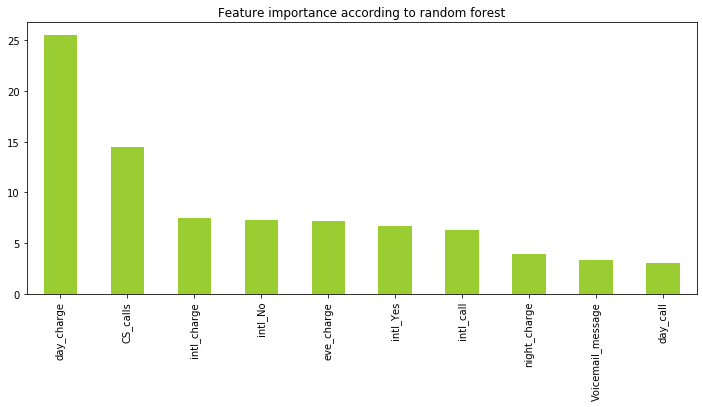

In [94]:
plt.figure(figsize=(12,5))
plt.title('Feature importance according to random forest')
top10.plot(kind='bar',color=['yellowgreen'])
plt.show()

According to Random Forest's feature importance, day charges is the most determining factor in customer churning, followed by customer service calls made. This 2 factors combine to almost 40%.

International charge and plan also affect prediction, having total feature importance of 27%

#### Key Assumption:
1. Many churning customers feel that company day charge is too expensive, in comparison with other networks.
2. Customer with more customer service calls tend to churn due to customer experience issue or complaints made due to company's charging or network.
3. Company's international service might have recurring issues that make customer unhappy, in both network and pricing.

#### Recommendation

1. Company need to monitor customer who made customer service calls -- Many CS calls could indicate that there is something wrong with the company that make customer unhappy.
2. Company need to have a good customer service team -- As the connector between company and customers, good customer service could give customer a good sense of idea of what company is all about. Bad service == customer dissatisfaction == higher probability of churn
3. Monitor day charge rate -- company need to make sure the rate is at reasonable level. Price too high == higher customer churn
4. Improve international service -- customer with international plan tend to churn more.

### Export chosen model for deploy

In [95]:
joblib.dump(forest_new,'randomforest')

['randomforest']